# Dataset: Pima Indians Diabetes Database

Data source and documentation [here](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download&select=diabetes.csv)

Data summary:
| **Column**                 | **Description**                                                        |
|----------------------------|------------------------------------------------------------------------|
| **Pregnancies**            | Number of times pregnant                                               |
| **Glucose**                | Plasma glucose concentration a 2 hours in an oral glucose tolerance test|
| **BloodPressure**          | Diastolic blood pressure (mm Hg)                                       |
| **SkinThickness**          | Triceps skin fold thickness (mm)                                       |
| **Insulin**                | 2-Hour serum insulin (mu U/ml)                                         |
| **BMI**                    | Body mass index (weight in kg/(height in m)^2)                         |
| **DiabetesPedigreeFunction** | Diabetes pedigree function                                           |
| **Age**                    | Age (years)                                                            |
| **Outcome**                | Class variable (0 or 1) 268 of 768 are 1, the others are 0             |



# Install Packages

In [1]:
!pip install lime

# Imports

In [ ]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,  roc_curve, auc, make_scorer
from sklearn.preprocessing import StandardScaler

import lime.lime_tabular


from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from utils import display_metrics
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

# Helper Function

In [4]:
def measure_metrics(model, X, y):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    return {'f1_score':f1, 'recall':recall, 'precision':precision}

def display_metrics(clf, X_train, y_train, X_test, y_test):

    train_metrics = measure_metrics(clf,X_train,y_train)
    test_metrics = measure_metrics(clf,X_test,y_test)

    metrics_data = pd.DataFrame([train_metrics,test_metrics],index=['Train metrics', 'Test metrics'])

    return metrics_data

# **1. Load Data**

In [3]:
data_source = "diabetes.csv"
data_raw = pd.read_csv(data_source)
data = data_raw.copy()

data.head(3)
data.shape

(768, 9)

# Exploratory Data Analysis - EDA

Let's check how the dataframe looks like

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Summary Statistics of the dataset

In [5]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Plot histogram for each feature

In [ ]:
hists = data.hist(bins=35, figsize=(15,15))
plt.show()

Plot heatmap of correlations between the variables

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

In [ ]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap= 'viridis',fmt='.2f')
plt.title('Correlation Matrix for Prima Diabetes dataset')
plt.show()

Boxplots for each variable, separated by the class (Outcome 0 or 1 wether or not a patient has diabetes)

In [ ]:
variables = data.drop(columns='Outcome').columns

In [ ]:
plt.figure(figsize=(15, 15))
for i, var in enumerate(variables):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='Outcome', y=var, data=data, hue='Outcome', palette='coolwarm')
    plt.title(f'Boxplot of {var} by Outcome')
    plt.xlabel('Outcome')
    plt.ylabel(var)
    plt.legend([],[], frameon=False)  # Remove the legend

plt.tight_layout()
plt.show()

Pairplot with kernel density estimates (KDE):
- Pairwise relationships visualizations between variables as well as the distribution of individual variables, categorized by outcome.

In [ ]:
sns.pairplot(data, hue = 'Outcome', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height = 4)

# Logistic Regression: Our first model

### Select X and y data

In [4]:
X = data.drop('Outcome', axis=1)  # Independent variables
y = data['Outcome']  # Dependent variable (target)

In [7]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [8]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

### Train/Test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
# Checking the shapes to get an understanding of the problem
print( X_train.shape, X_test.shape )
print( y_train.shape, y_test.shape )

### Standardization

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Note:** It is important to normalize/standardize the features (independent variables) before fitting a model for:
- Scale consistency
- Algorithm sensitivity
- Interpretability

In this case we choosed bu using 'StandardScaler()' function from sklearn, which scale features so that they have a mean of 0 and a standard deviation of 1.

### Logistic Regression

Train the Model

In [ ]:
# Create an instance of LogisticRegression
log_reg = LogisticRegression(max_iter=1000)  # Increase max_iter if needed

# Train the Logistic Regression model
log_reg.fit(X_train, y_train)

Predictions

In [ ]:
# Make predictions on the test set
y_predict = log_reg.predict(X_test)

In [ ]:
y_predict

In [ ]:
y_test.to_numpy()

Evaluate the model

In [ ]:
accuracy = accuracy_score(y_test, y_predict)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

In [ ]:
conf_matrix = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_reg.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

**Note:** 

Be caraful!! Sometime the datasets are unbalanced, i.e., the distribution of the classes is not similar

**Strategy 1:** Let the model know, that needs to give more weight to the positive class

In [ ]:
y_train.value_counts()

In [ ]:
# Create an instance of LogisticRegression
log_reg_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')  # Increase max_iter if needed

# Train the Logistic Regression model
log_reg_balanced.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set
y_predict_bal = log_reg_balanced.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_predict_bal)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

In [ ]:
conf_matrix = confusion_matrix(y_test, y_predict_bal)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_reg_balanced.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

**Strategy 2:** Change the thresholds of the model 

Logistic Regression outputs are probabilities!!

In [ ]:
# Make predictions on the test set
y_predict_probs = log_reg.predict_proba(X_test)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_predict_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Evaluation metrics for different thresholds

In [ ]:
# Define a list of thresholds
thresholds = np.arange(0.1, 1.1, 0.1)

# Initialize lists to store results
precisions = []
recalls = []
f1_scores = []

# Calculate metrics for each threshold
for threshold in thresholds:
    y_pred_threshold = (y_predict_probs >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

In [ ]:
# Create a DataFrame to store results
metrics_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
})
metrics_df

Precision & Recall

![](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fed5e3e1c-1c01-4a43-8cec-7c53d81a1b4c_1858x1240.png)

### How can we interpret the model coefficients?

For Logistic Regression we can compute the odds ratio!!

In [ ]:
# Extract coefficients and feature names
coefficients = log_reg.coef_[0]
feature_names = X.columns

- Coefficients > 0 have a positive impact in the positive class
- Coefficients < 0 have a negative impact in the positive class

In [ ]:
coefficients

In [ ]:
feature_names

In [ ]:
# Calculate log odds
log_odds = np.exp(coefficients)

In [ ]:
# Sort coefficients and feature names by absolute log odds
sorted_indices = np.argsort(np.abs(log_odds))[::-1]
sorted_feature_names = feature_names[sorted_indices]
sorted_log_odds = log_odds[sorted_indices]

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_log_odds, color=['skyblue' if coef > 1 else 'salmon' for coef in sorted_log_odds])
plt.xlabel('Logistic Regression Coefficients')
plt.title('Impact of Features on Diabetes Outcome (Log Odds)')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

# Model Generalization: Overfitting & cross-validation

Some machine learning models are very powerful, in the sense that they have the capability of learning complex patterns in data. That is the case for [RandomForests]()

In [ ]:
# target column  is called "Class"
target_col = 'Outcome'
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=[target_col]), data[target_col], test_size=0.3, random_state=42)

In [ ]:
# Define the model and hyperparameters
clf = RandomForestClassifier(random_state=42, 
                             n_estimators=1000,
                             max_depth=100, 
                             min_samples_split=2, 
                             min_samples_leaf = 1, 
                             max_features = 30,
                             min_impurity_decrease = 0.0,
                             ccp_alpha = 0.0,
                             bootstrap=False
                             )

In [ ]:
# fit the model to the training data
clf.fit(X_train, y_train)

In [ ]:
display_metrics(clf, X_train, y_train, X_test, y_test)

This model is overfitting because it has much better performance in the data it was trained on than on unseen data. This means that it learned even the noise in the data - essentially it memorized how to perfectly predict the training data. By memorizing this data, it didn't learn the underlying processes/rules that actually define the correlation between the `features` and the `target`.

![](https://www.sharpsightlabs.com/wp-content/uploads/2024/02/cross-validation-explained_FEATURED-IMAGE.png)

(meme - enter cross validation and grid search)

In to prevent overfitting, there are two things we can do:
1. Perform a `grid search` where we train multiple models and select only the best performing one on unseen data
2. Perform `cross validation` where our estimation of the model's generalization is more accurate

In [ ]:
# create a dictionary to vary several hyperparameters of the Model
param_grid = {
    'n_estimators': [5, 10,20,40,60],
    'max_depth': [None, 2,5,10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 2,5,10],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'ccp_alpha': [0.0, 0.1, 0.2]
}

In [ ]:
# define how we want to perform the grid search
random_search = RandomizedSearchCV(clf, 
                                   random_state=42,
                                   param_distributions=param_grid,
                                   n_iter=100, 
                                   scoring='f1', 
                                   cv=5, 
                                   n_jobs=-1, 
                                   verbose=2)

input here image of cross validation

In [ ]:
random_search.fit(X_train, y_train)

In [ ]:
pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score').head(5)

In [ ]:
# show dataframe with all performances
best_model = random_search.best_estimator_

In [ ]:
print('Metrics of overfitting model')
display(display_metrics(clf, X_train, y_train, X_test, y_test))

print('Metrics of best model from Grid Search')
display(display_metrics(best_model, X_train, y_train, X_test, y_test))

# Decision Threshold

In reality most models produce a probability as prediction and we have to decide if we accept that probability as `class 1` or `class 0`. By default, anything above 0.5 is considered `class 1`, however, it is not always clear that it should be this way:

In [ ]:
probas = best_model.predict_proba(X_train)[:,1]

# iterate the decision threshold between 0.1 and 0.9 and compute precision, recall and f1
# save results in a dictionary where the key is the threhsold and the value is a list of the metrics
thresholds = np.linspace(0.1, 0.9, 9)
metrics = {}
for threshold in thresholds:
    y_pred = (probas > threshold).astype(int)
    metrics[threshold] = [precision_score(y_train, y_pred), recall_score(y_train, y_pred), f1_score(y_train, y_pred)]

results = pd.DataFrame(metrics,index=['precision','recall','f1 score']).T.rename_axis(index='decision threshold')
results

In [ ]:
results.plot(title='Metrics by Decision Threshold', figsize=(10, 5))

## Rules of Thumb for Decision Threshold Adjustment in Healthcare

1. **Evaluate the Cost of Errors**:
   - Assess the clinical and psychological impact of false positives and false negatives for each specific test or model.
   - High cost of false positives (e.g., **invasive procedures**, **anxiety**) -> Higher precision.
   - High cost of false negatives (e.g., **missed diagnoses**, **delayed treatment**) -> Higher recall.

2. **Consider the Prevalence of the Condition**:
   - Rare conditions: High precision is often preferred due to the low base rate.
   - Common conditions: High recall is often preferred to catch as many cases as possible.

3. **Adjust for Context and Use Case**:
   - Screening vs. Diagnostic: Screening tests may prioritize recall to identify potential cases, while diagnostic tests may prioritize precision to confirm a diagnosis.
   - Preventive vs. Reactive: Preventive measures (e.g., vaccinations, regular screenings) may favor high recall, while reactive measures (e.g., treatment plans) may favor high precision.

# Decision Tree

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [6]:
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

#### **4.1.1 Decision Trees - Predictions**

In [7]:
display_metrics(dtree, X_train, y_train, X_test, y_test)

,f1_score,recall,precision
Train metrics,1.00,1.000000,1.000000
Test metrics,0.62,0.659574,0.584906


#### **4.1.2 Decision Trees - Visualize Tree**

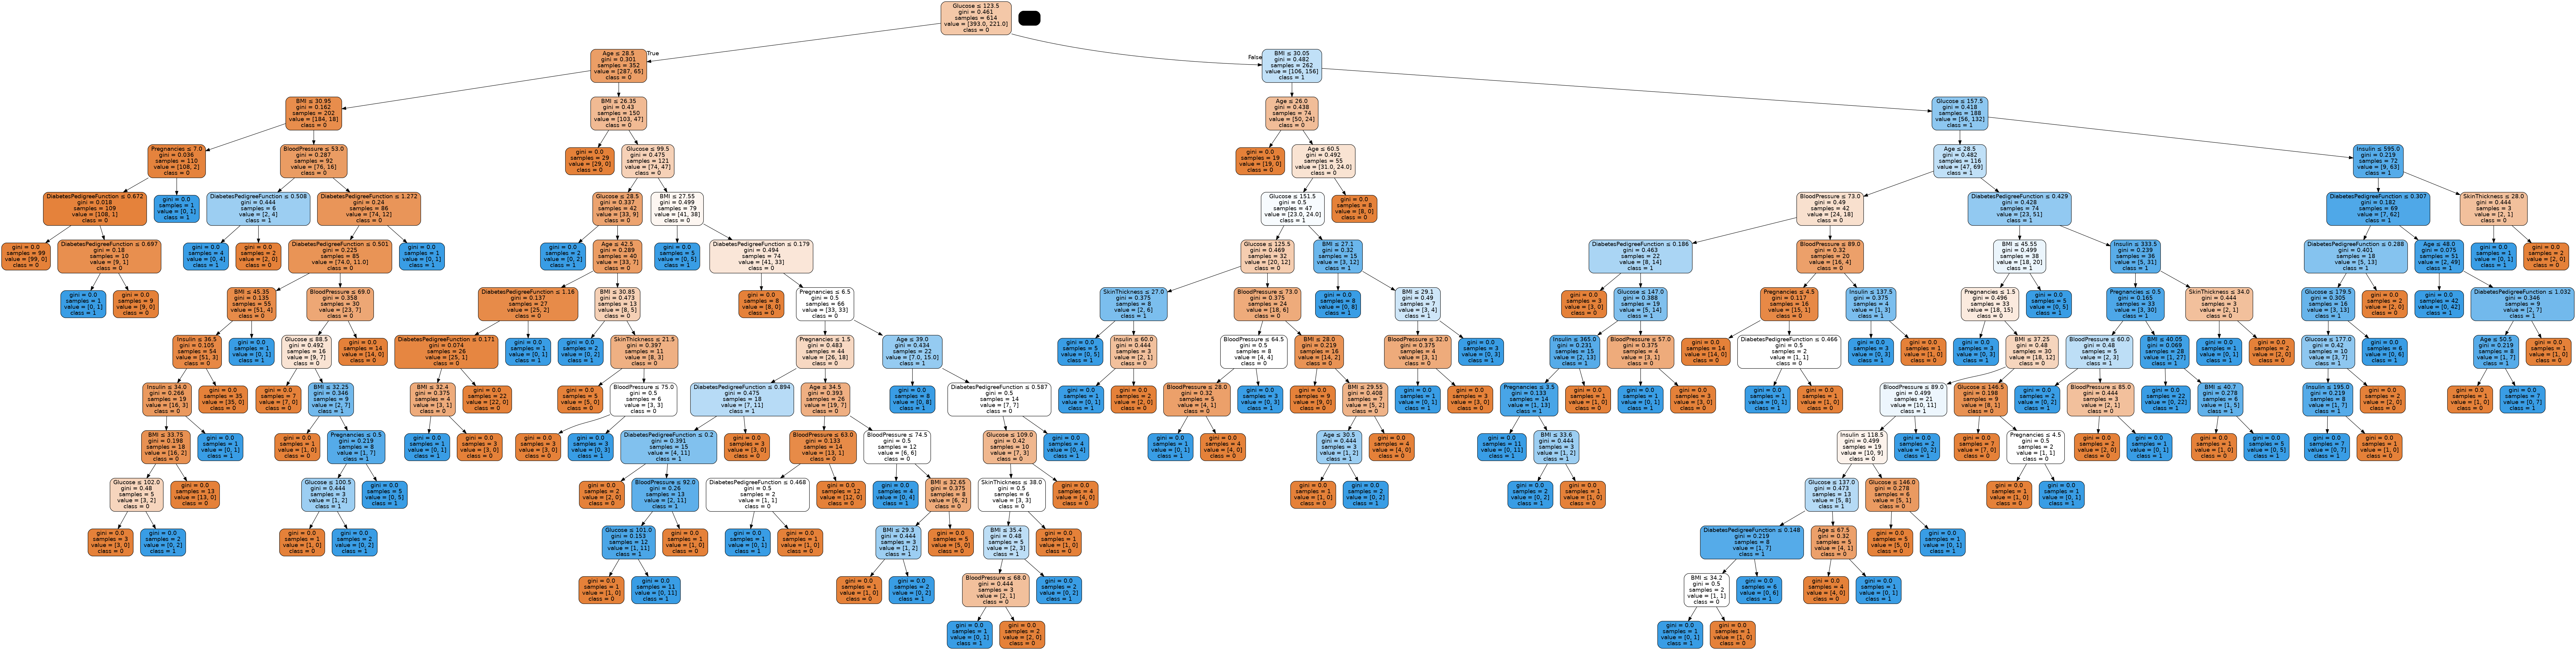

In [8]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns,class_names=['0','1']
                )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

![](https://miro.medium.com/v2/resize:fit:1394/1*6-ctYxKmTS8v0RzwLILfXA.png)

#### **4.1.3 Decision Trees - Explanation**

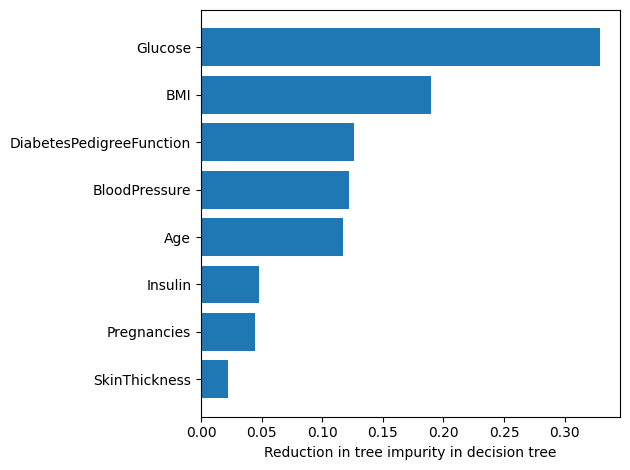

In [9]:
# Feature importance dataframe
imp_df = pd.DataFrame({'feature': X.columns,
                       'importance': dtree.feature_importances_})
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='importance')
imp_range=range(1,len(imp_df.index)+1)
 
## Barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))


# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Reduction in tree impurity in decision tree")

plt.tight_layout()
# Show graphic
plt.show()



In [24]:
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['0','1'], discretize_continuous=True)

InvalidIndexError: (slice(None, None, None), 0)

In [49]:
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train, 
                                 discretize_continuous=True)

InvalidIndexError: (slice(None, None, None), 0)

In [43]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

X_explain = X_test
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train,
                                                   feature_names=X.columns,
                                                   discretize_continuous=True,
                                                   class_names=["0", "1"],
                                                   mode="classification",
                                                   verbose=True)

#Explaining first subject in test set using all 30 features
exp = explainer.explain_instance(X_explain[20,:], dtree.predict_proba, 
                                 num_features=10)
#Plot local explanation
plt = exp.as_pyplot_figure()
#plt.tight_layout()
exp.show_in_notebook(show_table=True)

InvalidIndexError: (slice(None, None, None), 0)

#### **4.2 Multilayer Perceptron**

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from keras_tqdm import TQDMNotebookCallback

model = Sequential()
model.add(Dense(16, input_dim=(9), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

history= model.fit(X_train, Y_train,batch_size=16,validation_split=0.2, epochs=30,verbose=2)



In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **4.2.1 Multilayer Perceptron - Predictions**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

Y_pred = model.predict(X_test,verbose=0)
Y_pred = [ 1 if y>=0.5 else 0 for y in Y_pred]
cm = confusion_matrix(Y_test, Y_pred)

df_cm = pd.DataFrame(cm, index = ["Benign", "Malign"],
                  columns = ["Benign", "Malign"])
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
plt.show()
print(accuracy_score(Y_test, Y_pred))

#### **4.2.2 Multilayer Perceptron - Explanation**

In [ ]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np

def predict(qc):
    global model
    prediction_Class_1 = model.predict_proba(qc) 
    x = np.zeros((prediction_Class_1.shape[0], 1))
    probability = (x + 1) - prediction_Class_1
    final = np.append(probability,prediction_Class_1, axis=1)
    return final

X_explain = X_test
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train,
                                                   feature_names=["Clump Thickness","Uniformity of Cell Size ","Uniformity of Cell Shape", "Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nucleoli", "Bland Chromatin"," Normal Nucleoli", "Mitoses"],
                                                   discretize_continuous=True,
                                                   class_names=["benign", "malign"],
                                                   mode="classification",
                                                   verbose=True)
print(np.array([X_test[0,:]]).shape)
print(model.predict_proba(np.array([X_test[0,:]])))

#Explaining first subject in test set using all 30 features
exp = explainer.explain_instance(X_test[21,:], predict,num_features=10)
#Plot local explanation
plt = exp.as_pyplot_figure()
#plt.tight_layout()
exp.show_in_notebook(show_table=True)

## THE END 